In [272]:
import networkx as nx
import matplotlib.pyplot as plt

In [273]:
def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(120, 90), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

In [274]:
edges = pd.DataFrame(
    {
        "source": [0, 1, 2, 0],
        "target": [2, 2, 3, 2],
        "my_edge_key": ["A", "B", "C", "D"],
        "weight": [3, 4, 5, 6],
        "color": ["red", "blue", "blue", "blue"],
    }
)
G = nx.from_pandas_edgelist(
edges,
edge_attr=["weight", "color"],
create_using=nx.MultiGraph())

G[0]

AdjacencyView({2: {0: {'weight': 3, 'color': 'red'}, 1: {'weight': 6, 'color': 'blue'}}})

In [4]:
import pandas as pd
import re
import spacy
import neuralcoref

nlp = spacy.load('en_core_web_lg')
neuralcoref.add_to_pipe(nlp)


def entity_pairs(text, coref=True):
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
    if coref:
        text = nlp(text._.coref_resolved)  # resolve coreference clusters
    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = list()
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = spacy.util.filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span) for span in spans]
        dep = [token.dep_ for token in sent]
        if (dep.count('obj')+dep.count('dobj'))==1 \
                and (dep.count('subj')+dep.count('nsubj'))==1:
            for token in sent:
                if token.dep_ in ('obj', 'dobj'):  # identify object nodes
                    subject = [w for w in token.head.lefts if w.dep_
                               in ('subj', 'nsubj')]  # identify subject nodes
                    if subject:
                        subject = subject[0]
                        # identify relationship by root dependency
                        relation = [w for w in token.ancestors if w.dep_ == 'ROOT']  
                        if relation:
                            relation = relation[0]
                            # add adposition or particle to relationship
                            if relation.nbor(1).pos_ in ('ADP', 'PART'):  
                                relation = ' '.join((str(relation),
                                        str(relation.nbor(1))))
                        else:
                            relation = 'unknown'
                        subject, subject_type = refine_ent(subject, sent)
                        token, object_type = refine_ent(token, sent)
                        ent_pairs.append([str(subject), str(relation), str(token),
                                str(subject_type), str(object_type)])
    filtered_ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(x) == '' for x in sublist)]
    pairs = pd.DataFrame(filtered_ent_pairs, columns=['subject',
                         'relation', 'object', 'subject_type',
                         'object_type'])
    print('Entity pairs extracted:', str(len(filtered_ent_pairs)))
    return pairs


def refine_ent(ent, sent):
    unwanted_tokens = (
        'PRON',  # pronouns
        'PART',  # particle
        'DET',  # determiner
        'SCONJ',  # subordinating conjunction
        'PUNCT',  # punctuation
        'SYM',  # symbol
        'X',  # other
        )
    ent_type = ent.ent_type_  # get entity type
    if ent_type == '':
        ent_type = 'NOUN_CHUNK'
        ent = ' '.join(str(t.text) for t in
                nlp(str(ent)) if t.pos_
                not in unwanted_tokens and t.is_stop == False)
    elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
        t = ''
        for i in range(len(sent) - ent.i):
            if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                t += ' ' + str(ent.nbor(i))
            else:
                ent = t.strip()
                break
    return ent, ent_type

ModuleNotFoundError: No module named 'neuralcoref'

### KG Example1

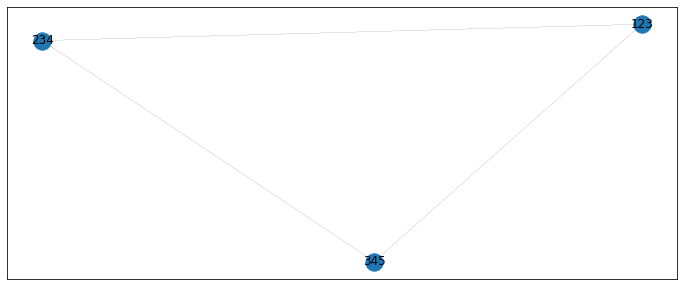

In [242]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

df = pd.DataFrame({'number':['123','234','345'],'contactnumber':['234','345','123'],'callduration':[0.1,0.1,0.1]})

df

G = nx.from_pandas_edgelist(df,'number','contactnumber', edge_attr='callduration')
durations = [i['callduration'] for i in dict(G.edges).values()]
labels = [i for i in dict(G.nodes).keys()]
labels = {i:i for i in dict(G.nodes).keys()}

fig, ax = plt.subplots(figsize=(12,5))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, ax = ax, labels=True)
nx.draw_networkx_edges(G, pos, width=durations, ax=ax)
_ = nx.draw_networkx_labels(G, pos, labels, ax=ax)

In [23]:
import numpy as np
import pandas as pd
import ampligraph

In [24]:
ampligraph.__version__

'1.3.2'

In [25]:
import requests

In [31]:
import numpy as np
from ampligraph.datasets import load_from_csv
url = 'https://hostname-s3-eu-west-1.amazonaws.com/datasets/GoT.csv'
open('GoT.csv', 'wb').write(requests.get(url).content)
X = load_from_csv('.', 'GoT.csv', sep=',')
X[:5, ]

array([['Smithyton', 'SEAT_OF', 'House Shermer of Smithyton'],
       ['House Mormont of Bear Island', 'LED_BY', 'Maege Mormont'],
       ['Margaery Tyrell', 'SPOUSE', 'Joffrey Baratheon'],
       ['Maron Nymeros Martell', 'ALLIED_WITH',
        'House Nymeros Martell of Sunspear'],
       ['House Gargalen of Salt Shore', 'IN_REGION', 'Dorne']],
      dtype=object)

In [32]:
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
entities

array(['Abelar Hightower', 'Acorn Hall', 'Addam Frey', ..., 'the Antlers',
       'the Paps', 'unnamed tower'], dtype=object)

In [33]:
relations = np.unique(X[:, 1])
relations

array(['ALLIED_WITH', 'BRANCH_OF', 'FOUNDED_BY', 'HEIR_TO', 'IN_REGION',
       'LED_BY', 'PARENT_OF', 'SEAT_OF', 'SPOUSE', 'SWORN_TO'],
      dtype=object)

In [34]:
from ampligraph.evaluation import train_test_split_no_unseen 

X_train, X_test = train_test_split_no_unseen(X, test_size=100)

In [35]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)

Train set size:  (3075, 3)
Test set size:  (100, 3)


In [36]:
from ampligraph.latent_features import ComplEx

In [37]:
model = ComplEx(batches_count=100, 
                seed=0, 
                epochs=200, 
                k=150, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

In [38]:
positives_filter = X

In [39]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train, early_stopping = False)

Average Loss:   0.017603: 100%|██████████| 200/200 [04:02<00:00,  1.28s/epoch]


In [40]:
from ampligraph.latent_features import save_model, restore_model

### KG for Errors:

In [263]:
er_msg="""sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:244)
at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:244)
at scala.collection.immutable.List.foreach(List.scala:318)
at scala.collection.TraversableLike$class.map(TraversableLike.scala:244)
at scala.collection.AbstractTraversable.map(Traversable.scala:105)
at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
at java.lang.reflect.Method.invoke(Method.java:498)
at org.apache.spark.deploy.yarn.ApplicationMaster$$anon$2.run(ApplicationMaster.scala:561)
at java.lang.NumberFormatException.forInputString(NumberFormatException.java:65)
at java.lang.Integer.parseInt(Integer.java:592)
at java.lang.Integer.parseInt(Integer.java:615)
at scala.collection.immutable.StringLike$class.toInt(StringLike.scala:229)
at scala.collection.immutable.StringOps.toInt(StringOps.scala:31)""

In [264]:
'''import re
for i in er_msg.split("\nat"):
    match2=re.search(r'([\s\w.]+)', i)
    print(match2.group())
    match=re.search(r'(\([\w.-:\d]+\))', i)
    if match:
        print(match.group().strip("()").split(":"))
 '''   

'import re\nfor i in er_msg.split("\nat"):\n    match2=re.search(r\'([\\s\\w.]+)\', i)\n    print(match2.group())\n    match=re.search(r\'(\\([\\w.-:\\d]+\\))\', i)\n    if match:\n        print(match.group().strip("()").split(":"))\n '

In [265]:
import nltk
col1=[]
col2=[]
for i in er_msg.split("\nat"):
    match2=re.search(r'([\s\w.]+)', i)
    list1=list(nltk.bigrams(match2.group().split(".")))
    for j in list1:
        col1.append(j[0].strip(" "))
        col2.append(j[1])


In [266]:
message_df=pd.DataFrame({"source":col1,"target":col2,"edge":col2})

In [267]:
#message_df10=message_df.head(30)

In [268]:
G = nx.from_pandas_edgelist(message_df,'source','target', edge_attr='edge')

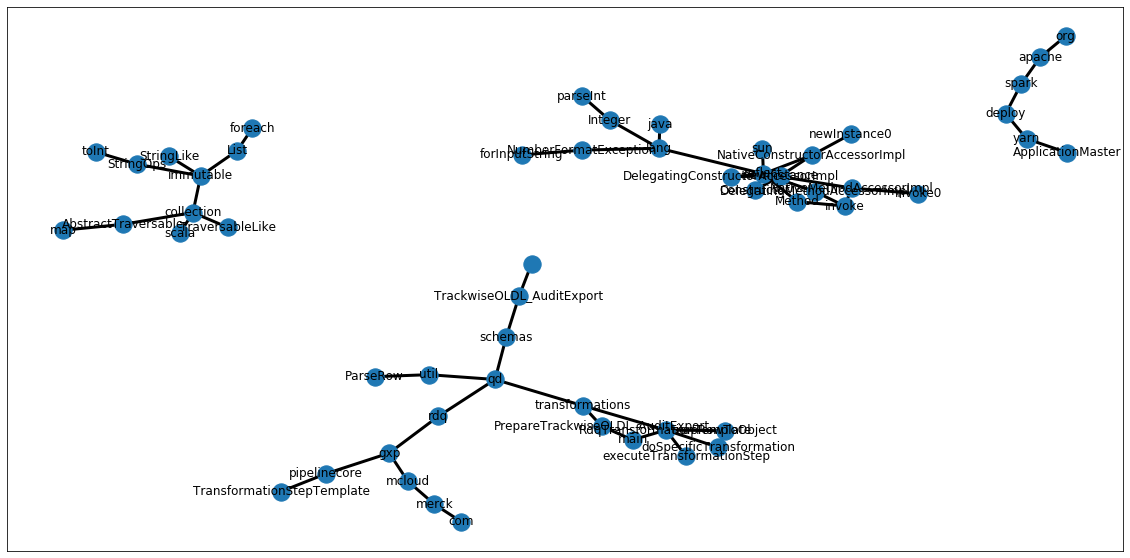

In [271]:
durations = [i['edge'] for i in dict(G.edges).values()]
#durations = [i['edge'] for i in dict(G.edges).values()]
#labels = [i for i in dict(G.nodes).keys()]
labels = {i:i for i in dict(G.nodes).keys()}

fig, ax = plt.subplots(figsize=(20,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, ax = ax, labels=True)
nx.draw_networkx_edges(G, pos, width=3, ax=ax)
_ = nx.draw_networkx_labels(G, pos, labels, ax=ax)


In [275]:
message_df=pd.DataFrame({"subject":col1,"object":col2,"edge":col2})

In [276]:
draw_kg

<function __main__.draw_kg(pairs)>